<h1> KNeighborsClassifier <h1>

Hauptkomponentenanalyse vor KNN?

In [538]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [539]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [540]:
def split_train_test(df):
    random_state = 4711
    features = [x for x in df.columns if x!= "RESP"]
    X = df[features]
    y = df["RESP"]
    X_train, X_test_2, y_train, y_test_2 = train_test_split(X, y, test_size = 0.05, random_state=random_state)
    X_train, X_test_1, y_train, y_test_1 = train_test_split(X_train, y_train, test_size = 0.2, random_state=random_state)
    return X_train, X_test_2, y_train, y_test_2, X_test_1, y_test_1

In [541]:
def get_result_score(y_test, y_predicted):

    TP = 0
    FP = 0
    TN = 0
    FN = 0

    y_true = y_test.to_list()
    y_predicted = y_predicted.tolist()

    for i in range(len(y_predicted)):
        if y_true[i]==y_predicted[i]==1:
            TP += 1
        if y_predicted[i]==1 and y_true[i]!=y_predicted[i]:
            FP += 1
        if y_true[i]==y_predicted[i]==0:
            TN += 1
        if y_predicted[i]==0 and y_true[i]!=y_predicted[i]:
            FN += 1


    return (TP*16+FP*(-2)+TN*(0)+FN*(-16))

In [542]:
path = r'./out/df_clean.csv'
df = pd.read_csv(path, sep=';', decimal=',')

In [543]:
X_train, X_test_2, y_train, y_test_2, X_test_1, y_test_1 = split_train_test(df)

In [544]:
bestfeatures_chi = SelectKBest(chi2, k=10).fit(X_train,y_train)
print("Score features: ", bestfeatures_chi.scores_)
print("Columns: ", X_train.columns)

Score features:  [7.92532247e+02 9.91655926e+04 2.19017723e+04 1.47413392e+06
 5.59555180e+02 4.71583791e+03 7.49366427e+04 7.51759158e+05
 5.98261095e+05 1.26059109e-01 4.45043935e+05 1.95442398e+05
 9.19000385e+05 1.18212014e+05 2.64298489e+00 3.66919477e+03
 4.61400938e+04 1.10599805e+05 1.76098892e+01 9.18079686e+03
 5.77610802e+03 7.52824429e+04 1.67969854e+03 2.54386853e+01
 4.13295101e+02 1.87921255e+03 5.64336065e+03 6.40697468e+02
 1.89833630e+02 1.20156338e+05 8.89532846e+01 3.72504081e-01
 1.12725717e+00 5.74727548e-01 1.42011200e+00 2.28723460e+00
 7.43103450e-01 6.43027854e-01 3.45769713e-01 1.21149887e-01
 2.72203129e-03 7.83966503e-01 2.50234309e-02 4.32362135e+00
 4.27873346e-02 7.98812232e-02 8.80326891e-01 3.02864614e-01
 4.04948860e+00 2.99783282e-01 3.07077837e-01 1.22104652e+00
 1.04736669e-02 8.31663865e-01 6.60540235e+00 2.47207737e+00
 2.58386424e+00 1.22522402e+00 2.09448851e-01 6.10951720e-01
 1.35142988e-01 3.40838015e+00 2.77675657e+00 9.17785332e-02
 1.6504

In [545]:
bestfeatures_classif = SelectKBest(f_classif, k=10).fit(X_train,y_train)
print("Score features: ", bestfeatures_classif.scores_)
print("Columns: ", X_train.columns)

Score features:  [6.74759809e-02 1.22960808e+03 3.26235277e+03 1.95725439e+03
 9.59458665e+02 7.07537970e+01 4.37809203e+01 7.20719788e+02
 1.02893096e+03 2.29788664e+02 1.29770652e+03 6.94870177e+02
 1.80391068e+03 4.20781725e+02 6.91386498e+01 8.67395708e+02
 5.57640277e+02 9.33437975e+02 1.99583505e+02 2.65059055e+03
 1.70258681e+03 2.50624767e+03 1.67267369e+03 1.82592172e+02
 4.42155520e+02 7.23368259e+02 2.27528959e+03 2.06489401e+03
 9.54122235e+02 1.71738166e+03 1.44483485e+01 3.73190203e-01
 1.24765156e+00 6.53107336e-01 1.48655904e+00 2.36545606e+00
 7.48392168e-01 6.47797836e-01 3.62774108e-01 1.29532834e-01
 2.74563222e-03 8.19732232e-01 2.50310448e-02 4.37454926e+00
 4.35868923e-02 8.00366449e-02 8.91381769e-01 3.15295162e-01
 4.12033479e+00 3.06600120e-01 3.07232329e-01 1.22217259e+00
 1.05948863e-02 8.34180123e-01 6.82759058e+00 2.48538774e+00
 2.58849970e+00 1.23805613e+00 2.09476867e-01 6.12494485e-01
 1.37355773e-01 3.42838774e+00 2.78548681e+00 9.56586844e-02
 1.6668

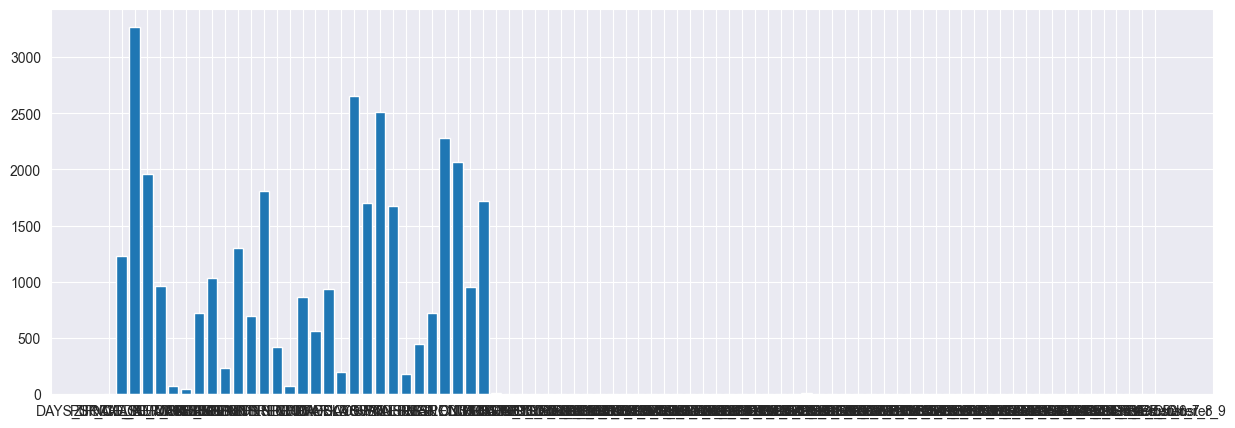

In [546]:
dict = {X_train.columns[i]: bestfeatures_classif.scores_[i] for i in range(len(X_train.columns))}
fig = plt.figure(figsize=(15, 5))
plt.bar(range(len(dict)),list(dict.values()),align="center")
plt.xticks(range(len(dict)), list(dict.keys()))
plt.show()

In [547]:
X_train = bestfeatures_classif.transform(X_train)
X_test_1 = bestfeatures_classif.transform(X_test_1)
X_test_2 = bestfeatures_classif.transform(X_test_2)

In [548]:
X_train

array([[1.0000e+00, 1.0800e+02, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.6550e+02],
       [1.0000e+00, 2.5560e+02, 2.5560e+02, ..., 0.0000e+00, 0.0000e+00,
        2.7000e+01],
       [8.0000e+00, 4.3124e+02, 2.3498e+02, ..., 2.0000e+00, 2.2220e-01,
        3.5660e+01],
       ...,
       [1.0000e+00, 1.8700e+02, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        1.1100e+02],
       [4.0000e+00, 1.4299e+02, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        4.2350e+01],
       [6.0000e+00, 1.7594e+02, 9.1980e+01, ..., 1.0000e+00, 5.0000e-01,
        4.2810e+01]])

### Scaling on z-values
### Auf Pipeline achten! Skalierung innerhalb der Pipeline durchführen

In [549]:
std_slc = preprocessing.StandardScaler()
knn = KNeighborsClassifier()

In [550]:
pipe = Pipeline(steps=[("std_slc", std_slc),
                       ("KNN",knn)])

In [551]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('std_slc', StandardScaler()), ('KNN', KNeighborsClassifier())])

In [552]:
mean_acc = np.zeros(30)
mean_score = np.zeros(30)
for i in range(1,31):
    pipe.set_params(KNN__n_neighbors=i).fit(X_train, y_train)
    y_predicted = pipe.predict(X_test_1)
    mean_acc[i-1] = metrics.accuracy_score(y_test_1, y_predicted)
    mean_score[i-1] = get_result_score(y_test_1, y_predicted)

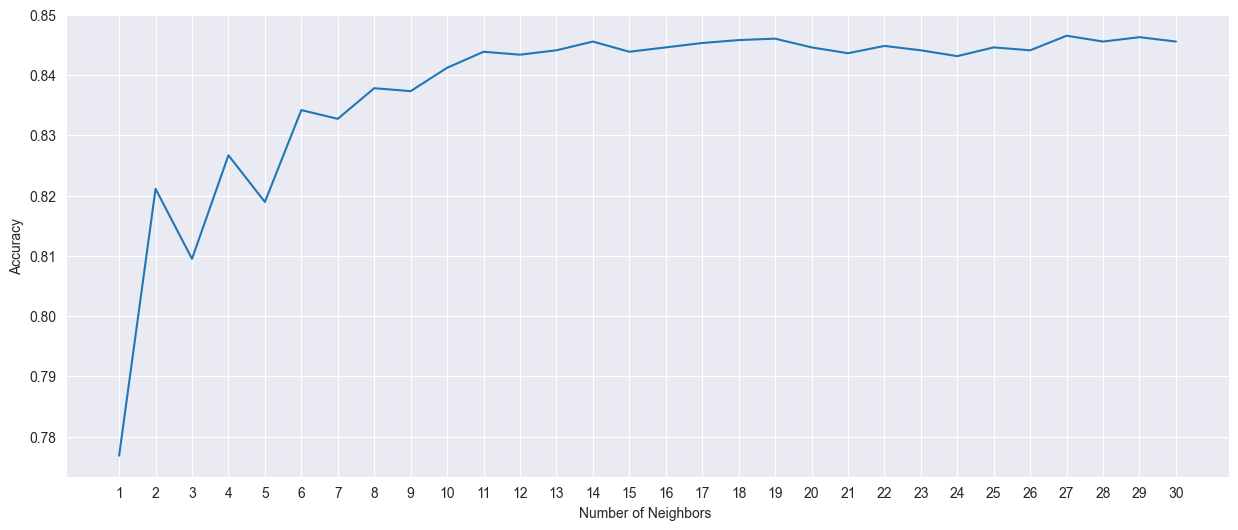

In [553]:
loc = np.arange(1,31,step=1.0)
plt.figure(figsize = (15, 6))
plt.plot(range(1,31), mean_acc)
plt.xticks(loc)
plt.xlabel('Number of Neighbors ')
plt.ylabel('Accuracy')
plt.show()

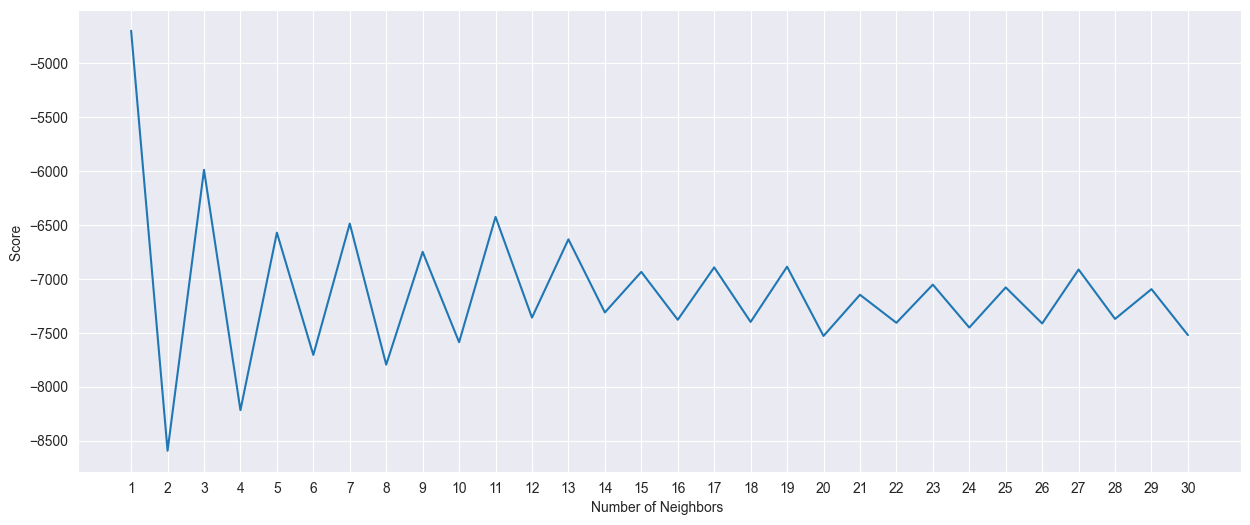

In [554]:
loc = np.arange(1, 31, step=1.0)
plt.figure(figsize=(15, 6))
plt.plot(range(1, 31), mean_score)
plt.xticks(loc)
plt.xlabel('Number of Neighbors ')
plt.ylabel('Score ')
plt.show()

In [555]:
grid_params = {"n_neighbors" : [1,2,5,7,9,11,13,15,17,19,20,100],
               "weights" : ["uniform","distance"],
               }
knn = KNeighborsClassifier()
result_scorer = make_scorer(get_result_score)
knn_random_result_score = GridSearchCV(estimator = knn, param_grid = grid_params,
                                       cv = 3, n_jobs = -1, scoring = result_scorer)
knn_random_result_accuracy = GridSearchCV(estimator = knn, param_grid = grid_params,
                                          cv = 3, n_jobs = -1)
knn_random_result_recall = GridSearchCV(estimator = knn, param_grid = grid_params,
                                        cv = 3, n_jobs = -1, scoring = "recall")
knn_random_result_score_res = knn_random_result_score.fit(X_train, y_train)
knn_random_result_accuracy_res = knn_random_result_accuracy.fit(X_train, y_train)
knn_random_result_recall_res = knn_random_result_recall.fit(X_train, y_train)

print("Bester Score: ",knn_random_result_score_res.best_score_)
print("Mit Parametern: ",knn_random_result_score_res.best_params_)
print("Beste Accuracy: ",knn_random_result_accuracy_res.best_score_)
print("Mit Parametern: ",knn_random_result_accuracy_res.best_params_)
print("Bester Recall: ",knn_random_result_recall_res.best_score_)
print("Mit Parametern: ",knn_random_result_recall_res.best_params_)

Bester Score:  -6276.0
Mit Parametern:  {'n_neighbors': 1, 'weights': 'uniform'}
Beste Accuracy:  0.8407578862350626
Mit Parametern:  {'n_neighbors': 100, 'weights': 'distance'}
Bester Recall:  0.3252658599193253
Mit Parametern:  {'n_neighbors': 1, 'weights': 'uniform'}


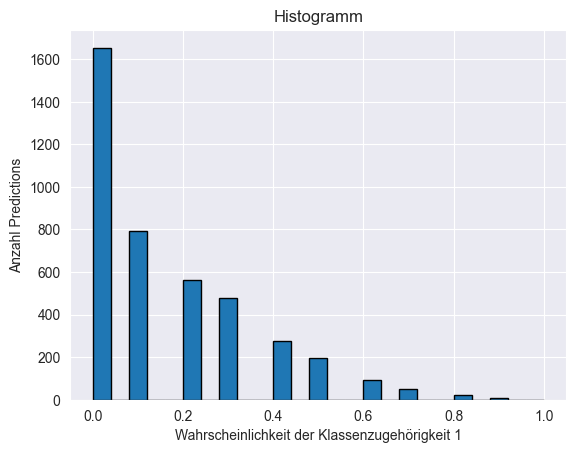

Accuracy:  52.62189512419503 %
Recall:  87.05882352941177 %
Precision:  23.08892355694228 %
F1 Score:  36.498150431565975 %
Score:  1030


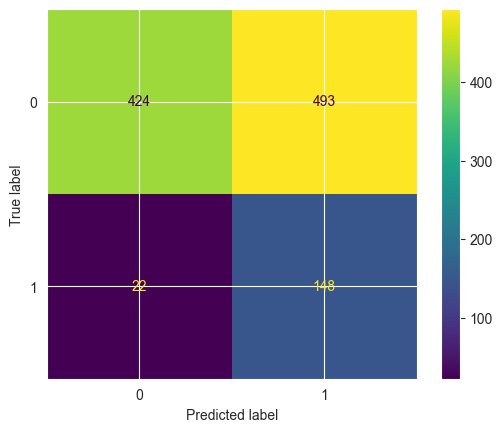

In [556]:
def to_labels(probabilities, threshold):
    return (probabilities >= threshold).astype("int")


knn = KNeighborsClassifier(n_neighbors=10, metric="manhattan", weights="uniform")


knn.fit(X_train,y_train)
y_predicted = (knn.predict_proba(X_test_2)[:,1]>=0.085).astype(bool)
accuracy = accuracy_score(y_test_2, y_predicted)
precision = precision_score(y_test_2, y_predicted)
recall = recall_score(y_test_2, y_predicted)
f1score = f1_score(y_test_2, y_predicted)
score = get_result_score(y_test_2, y_predicted)


#Thresholds evaluieren
knn.fit(X_train, y_train)
yhat = knn.predict_proba(X_test_1)
probs = yhat[:, 1]
plt.hist(probs, bins=25, edgecolor='black')
plt.xlabel('Wahrscheinlichkeit der Klassenzugehörigkeit 1')
plt.ylabel('Anzahl Predictions')
plt.title('Histogramm')
plt.show()

print("Accuracy: ",accuracy*100, "%")
print("Recall: ", recall*100, "%")
print("Precision: ", precision*100, "%")
print("F1 Score: ", f1score*100, "%")
print("Score: ", score)
matrix = confusion_matrix(y_test_2,y_predicted,labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=knn.classes_)
disp.plot()
plt.show()